# SimMod 1. Video features
## 1. Author Documentation

- Alexander Haberl (11806899)
- Alina Godun (01569197)

### Timesheets
#### Alexander Haberl

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 15:00-16:00 | Preparation for registration assesment test |
| 2023/10/10 | 18:45-19:10 | Registration assesment test |
| 2023/10/12 | 10:00-11:00 | Pre-lecture meeting |
| 2023/11/02 | 18:00-22:00 | Watching lectures 6 and 7 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/09 | 19:00-22:00 | Watching lectures 8 and 9 |
| 2023/11/19 | 16:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 00:00-02:30 | Writing abstracts for SimMod 1 and 2 |
| 2024/01/10 | 18:00-22:00 | SimMod 2 Research for i Vectors |
| 2024/01/11 | 18:00-22:00 | SimMod 2 Research and implementation for i Vectors |
| 2024/01/13 | 10:30-22:00 | SimMod 2 First audio features for Pigs and Cook |
| 2024/01/14 | 10:30-22:00 | SimMod 2 Video features for Pigs and Cook |
| 2024/01/14 | 23:00-01:00 | SimMod 2 Hand In Notebook |

#### Alina Godun

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 17:30-18:30 | Preparation for registration assesment test |
| 2023/10/10 | 19:10-19:30 | Registration assesment test |
| 2023/10/28 | 20:00-00:00 | Watching lectures 4 to 6 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/18 | 16:00-20:00 | Watching lectures 7 and 8 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 19:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 19:00-02:00 | Writing abstracts for SimMod 1 and 2 |
| 2024/01/13 | 10:30-22:00 | SimMod 2 Video features for Pigs and Cook |
| 2024/01/14 | 10:30-22:00 | SimMod 2 Audio features for Pigs and Cook |
| 2024/01/14 | 23:00-01:00 | SimMod 2 Hand In Notebook |

## 2. Environment
To install all required libraries, create a conda environment from the conda_env.yml file:

```conda env create -f conda_env.yml```

Then activate the environment:

```conda activate SimilarityModeling```

Start jupyterlab (optional):

```jupyter lab```

## 3. Train Test Splitting

We can't randomly sample frames, because two neighboring frames are very, very similar and would lead to data leakage.
Therefore we split each episode into 2 parts of approximately equal length. Cuts were made when a new scene started, ensuring that no scene is present in both parts. This results in 6 episode partitions in total. 

We perfom nested cross-validation. 5/6 splits are used for the inner CV-loop (4/6 are used for training and 1/6 is used for validation). The outer CV-loop uses 1/6 as a testset.

The inner CV-loop is for hyperparameter tuning. All parameter combinations of the classifiers are evaluated on on each of the inner CV-folds. The hyperparameter-combination that performs the best on average is chosen for each classifier. Then each classifier is retrained on the whole 5/6 of the train-validation data with its best hyperparameters and then evaluated on the test-set. The final result is the average for each classifier over all test-folds. The best model is the one that performs the best on the outer-loop on average. 

Basically the inner-loop is for automatic hyperparameter tuning (and we don't care about the actual values of the hyperparameters), while the outer loop is for model comparison.

By doing nested cross-validation, we don't have to ensure that the test-set is representative because all frames are used for testing. If we only did holdout we would have a test-set with stronger bias, which might favor one classifier.

Since Swedish Chef (Cook) has only a very minor amount of appearances in the dataset, during CV we skip folds, where Chef is not present in the train data. There are some folds, where Swedish Chef is not present in the outer test fold, but we still run the inner CV experiments since Swedish Chef will have an appearance in the validation fold of the inner CV, so the classifier performace is still being evaluated.

## 4. Feature extraction

### 4.1 Load Data

In [24]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from utils import io, train, eval
from utils import feature_engineering as fe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

In [26]:
extract_pig_color = False
extract_haralick = False

### 4.2 GrabCut foreground masks:
While our foreground detection based on the optical flow worked reasonably well in the SIM1 notebook, it was still far from being perfect. It especially often produced holes in the middle of the masks, which is why we had to perform some morphology operations to fill them. But these operations lead to masks that also included stretches of the background. Therefore we decided to use the more advanced GrabCut algorithm for foreground segmentation.

### 4.3 Pig Color
We use the more advanced GrabCut masks to count how many pig-like colors are in the foreground. We only used this feature because none of the 'advanced' video features (that we tried) worked.

In [27]:
if extract_pig_color:
    pig_color_feats = {}
    for episode in episode_names:
        feats = fe.get_pig_pixels(video_paths[episode])
        pig_color_feats[episode] = feats
        
    pickle.dump(pig_color_feats, open(os.path.join('../data/features/', 'pig_color_feats.pkl'), 'wb'))

### 4.4 Haralick Texture
We perform texture analysis based on haralick features of the foreground. Ideally only the characters are part of the foreground, which should lead to the haralick features only describing the texture of the characters. In reality the masks are not good enough to segment the characters, and instead the texture of a bigger scene is described, so the features don't perfom that well.

In [28]:
if extract_haralick:
    texture_feat = fe.extract_haralick_texture(video_paths, episode_names)
    pickle.dump(texture_feat, open(os.path.join('../data/features/', 'texture_feats.pkl'), 'wb'))


### 4.5 Failed approaches
**SIFT/ORB features and template based matching**

We wanted to test out advanced feature detection and description algorithms like SIFT and ORB. We wanted to extract some descriptors based on character images from the internet and then match the descriptors of those reference images to the current frame. The feature for the classifier would have been e.g. the number of matches to the reference images.
Unfortunately they did not work well, because the detected keypoints where mostly located at the edges of the characters. Therefore the SIFT and ORB descriptors included parts of the background as well, which means that the matching did not work well as the background changes across different scenes, and also inside the same scene, since the characters move around. This got a bit better with the background removal based on GrabCut, but the foreground detection from GrabCut is not perfect either so we still had issues. Additionally the keypoints often drastically changed for the same character, even if they were in the same scene and only did small amounts of movement. Also finding reference images for a wide range of camera angles and body positions of the characters would be quite hard to do. SIFT/ORB features probably only work well for static objects and not moving beings. Therefore we dropped these features.

**DCT and PCA**

We also tried to reduce the image information with DCT and PCA and use it as an input for classifier. Unfortunately, this did not work out, since both approaches either resulted in a very large amount of features which was too much for a classifier, or did not cover enough variability in the data to be a useful feature.


**Haar Cascade Classifier**

We also wanted to try object detection based on the haar cascade classifier. Unfortunately thousands of (distinct enough) positive and negative samples are needed for training, which we unfortunately do not have in the case of the Chef and the Pigs.

## 5. Classification

### 5.1 Load features
The (pre-)computed features are loaded from the ```data/features``` directory.

In [29]:
final_df = gt_df.copy()

In [30]:
pig_colors = pickle.load(open(os.path.join('../data/features/', 'pig_color_feats.pkl'), 'rb'))

for ep in episode_names:
    for feat_name, feat in pig_colors[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat

In [31]:
textures = pickle.load(open(os.path.join('../data/features/', 'texture_feats.pkl'), 'rb'))

for ep in episode_names:
    ep_textures = textures[ep]['texture']
    for i in range(ep_textures.shape[1]):
        final_df.loc[final_df['episode'] == ep, f'texture_{i}'] = ep_textures[:, i]

### 5.2 Run experiments

#### 5.2.1 Pigs

In [32]:
train_models = False
save_results = True
target_col = 'Pigs'
feat_type = 'video'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'pig_' in c
              or 'texture_' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- num_pig_pixels_foreground
- num_pig_pixels_background
- num_pig_pixels
- pig_pixels_ratio
- texture_0
- texture_1
- texture_2
- texture_3
- texture_4
- texture_5
- texture_6
- texture_7
- texture_8
- texture_9
- texture_10
- texture_11
- texture_12


In [33]:
clf_config = [
    {
        'model_name': 'linSVC',	
        'model': LinearSVC(),
        'param_grid': {
            'clf__dual': ['auto'],
            'clf__loss': ['hinge', 'squared_hinge'],
            'clf__class_weight': ['balanced']
        },
    },
    {
        'model_name': 'NaiveBayes',
        'model': GaussianNB(),
        'param_grid': {
        },
    },
    {
        'model_name': 'GM',
        'model': GaussianMixture(),
        'param_grid': {
            'clf__n_components': [2],
            'clf__init_params': ['kmeans', 'random'],
            'clf__max_iter': [100, 200]
        },
    }
]

In [34]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type)

#### 5.2.2 Cook

In [36]:
train_models = False
save_results = True
target_col = 'Cook'
feat_type = 'video'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'pig_' in c
              or 'texture_' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- num_pig_pixels_foreground
- num_pig_pixels_background
- num_pig_pixels
- pig_pixels_ratio
- texture_0
- texture_1
- texture_2
- texture_3
- texture_4
- texture_5
- texture_6
- texture_7
- texture_8
- texture_9
- texture_10
- texture_11
- texture_12


In [37]:
clf_config = [
    {
        'model_name': 'linSVC',	
        'model': LinearSVC(),
        'param_grid': {
            'clf__dual': ['auto'],
            'clf__loss': ['hinge', 'squared_hinge'],
            'clf__class_weight': ['balanced']
        },
    },
    {
        'model_name': 'NaiveBayes',
        'model': GaussianNB(),
        'param_grid': {
        },
    },
    {
        'model_name': 'GM',
        'model': GaussianMixture(),
        'param_grid': {
            'clf__n_components': [2],
            'clf__init_params': ['kmeans', 'random'],
            'clf__max_iter': [100, 200]
        },
    }
]

In [38]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type)

## 6. Results & Discussion

#### 6.1 Pigs

In [39]:
target_col = 'Pigs'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_video_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_video_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_video_tpr_info.pkl", "rb"))

In [40]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

The following curves provide infomation about precision, recall, TPR and FPR for all experiment runs and parameter combinations, both from inner and outer CV loops.

As we can see, all classifiers have a high recall, but quite low precision, probably due to small amount of samples for the positive class, which make it's identification quite complicated. We can also see from the ROC curve, that classifiers managed to achieve high TPR, but FPR is also quite high.

The performance of all classifiers is comparable.

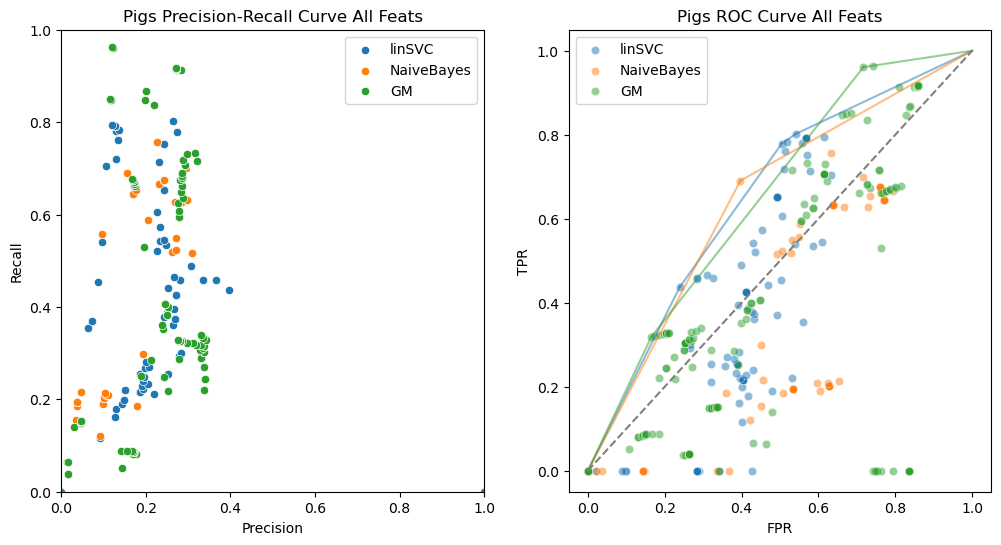

In [42]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0], sim_mod='SimMod2', plot_curve=False)
eval.plot_roc_curve(fpr_dict, tpr_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1], sim_mod='SimMod2')

The following curves provide the information about TPR and FPR at different classification thresholds for the best hyperparameter combinations of each model. It also shows that the classification is very challenging, probably because of not having enough positive samples and extracted features not being good enough. We can also see that the result is very test-train split dependent, which might indicate that we don't have enough positive samples. The features are not good enough to cover the underlying complexity of the data either.

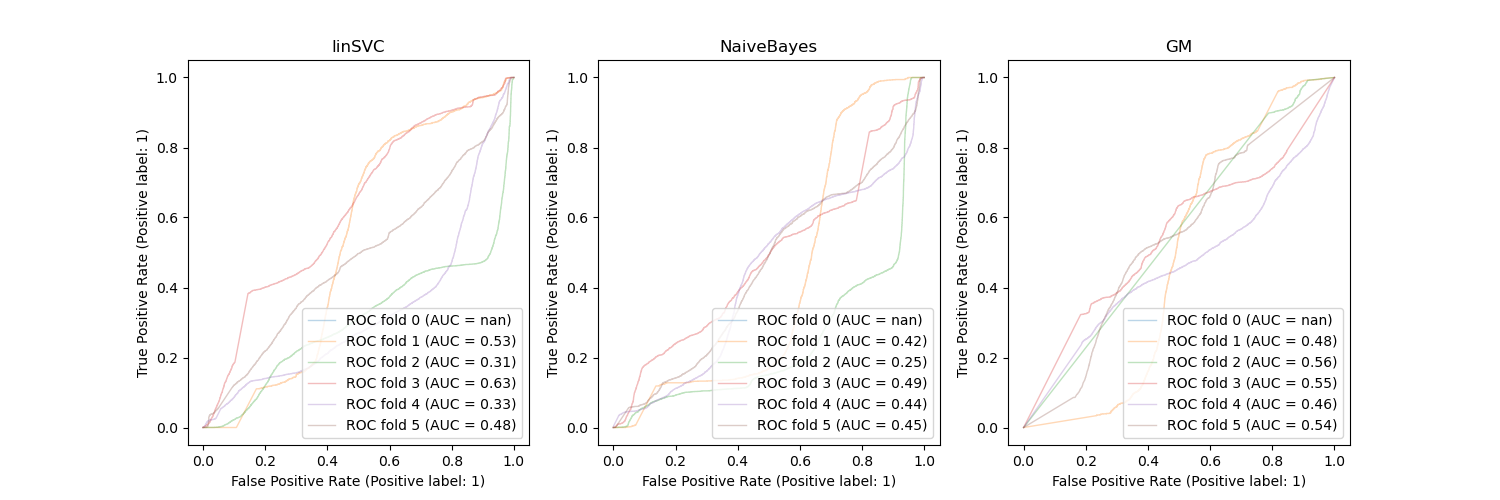

In [43]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

#### 6.2 Cook

In [20]:
target_col = 'Cook'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_video_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_video_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_video_tpr_info.pkl", "rb"))

In [21]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

As we can see, the performance for the Swedish chef is also not very good. While the recall (TPR) is very high, the precision is very close to 0. There are also some runs where TPR is high while FPR is okayish. There is little difference in performance across difference models.

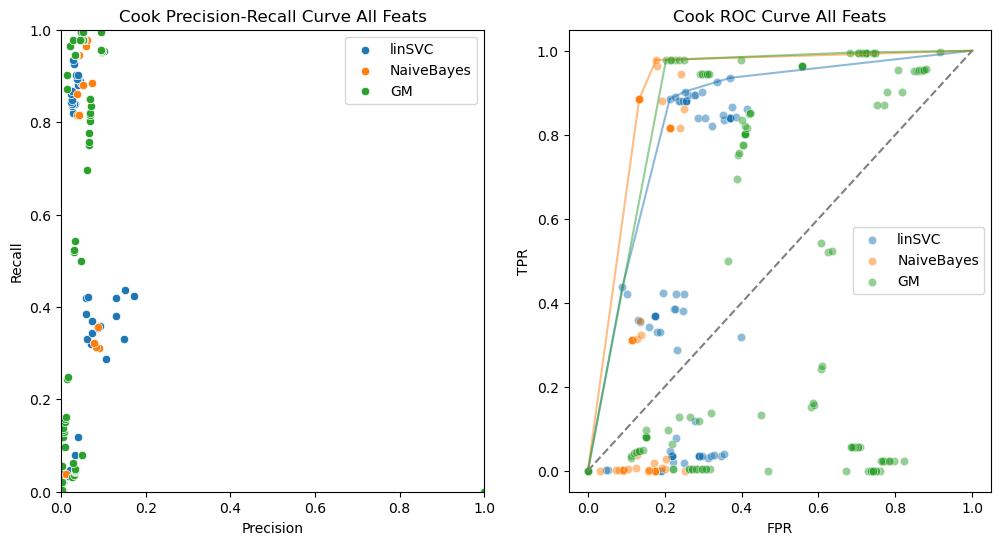

In [22]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0], plot_curve=False, sim_mod='SimMod2')
eval.plot_roc_curve(fpr_dict, tpr_dict, clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1], sim_mod='SimMod2')


The following curves also demonstrate that the performance of the classifier is extremely fold dependent (which makes sense, since we only have 2 scenes with Swedish chef in the dataset).

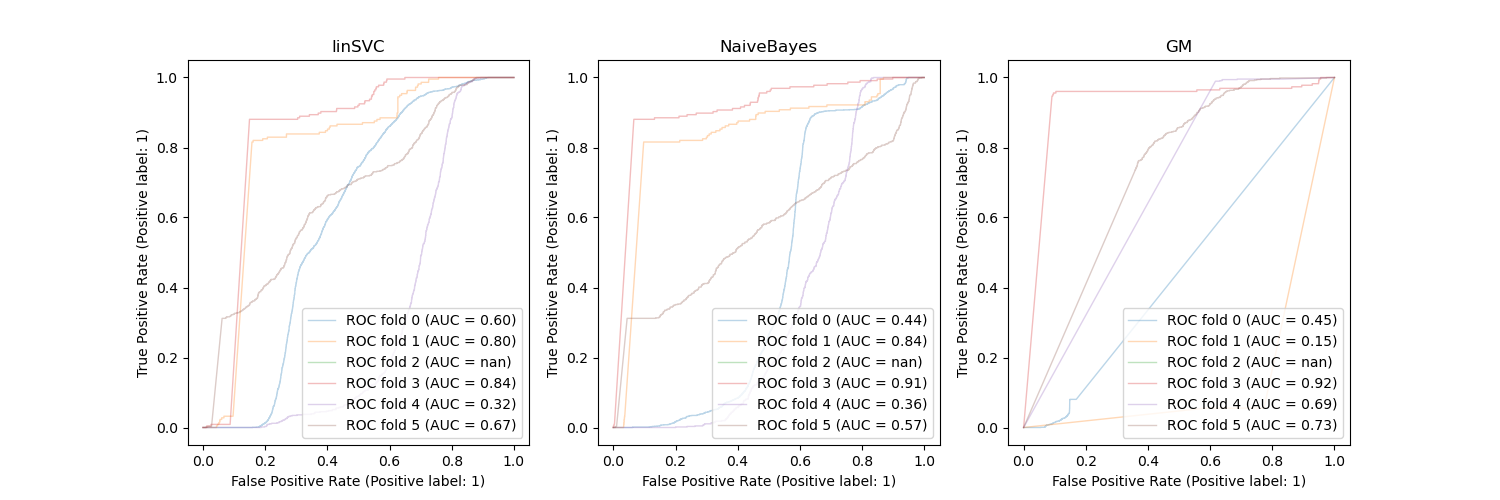

In [23]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

## 7. Conclusion
The classification of Pigs and Swedish chef was very challenging. The first reason is that the dataset is heavily imbalanced, there is a very little number of positive samples in comparison to the negative samples. Especially in case with Swedish chef: he only has 2 scenes, and if one wants to avoid data leakage, one cannot split these scenes into multiple parts, since frames look very similar to each other and we would basically test on the same data we've used for training. This means that we can only train classifier on one scene, which is not enough to create a good classifier.

Another challenge was that the approaches from SimMod2 were not really applicable to this classification problem, since they often required large amount of positive samples or were aimed at static non-changing objects, while in the videos the characters move a lot.